### **WEEK TWO: SDS-CP041-neuroscan**

Author: Sheila Adams-Sapper

Date: October 2025

Dataset: https://www.kaggle.com/datasets/arwabasal/brain-tumor-mri-detection

OBJECTIVES:
1. Build and train CNN with class weights
2. Track experiments with MLflow
3. Perform hyperparameter tuning
4. Optimize decision threshold
5. Comprehensive evaluation and comparison

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mlflow

In [2]:
import time
import json
from datetime import datetime

# Machine Learning
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score, precision_score, recall_score
)
from sklearn.utils import class_weight

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
)

# MLflow
import mlflow
import mlflow.keras
import mlflow.tensorflow

import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Color palette (consistent with Week One)
TUMOR_COLOR = '#FF6B6B'
NO_TUMOR_COLOR = '#4ECDC4'
PALETTE = [NO_TUMOR_COLOR, TUMOR_COLOR]

# Set style
plt.style.use('default')
sns.set_palette(PALETTE)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Model configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('mlflow_artifacts', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("="*70)
print("BRAIN TUMOR CNN DETECTION - MODEL DEVELOPMENT WITH MLFLOW")
print("="*70)
print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"MLflow version: {mlflow.__version__}")

BRAIN TUMOR CNN DETECTION - MODEL DEVELOPMENT WITH MLFLOW

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: False
MLflow version: 3.4.0


In [4]:
# ============================================================================
# MLFLOW SETUP
# ============================================================================

print("\n" + "="*70)
print("MLFLOW EXPERIMENT SETUP")
print("="*70)

# Set MLflow tracking URI (local directory)
mlflow.set_tracking_uri("file:./mlflow_artifacts/mlruns")

# Create or set experiment
experiment_name = "Brain_Tumor_CNN_Detection"
mlflow.set_experiment(experiment_name)

print(f"\n✅ MLflow experiment: {experiment_name}")
print(f"📁 Tracking URI: ./mlflow_artifacts/mlruns")
print(f"💡 View experiments: Run 'mlflow ui' in terminal")



MLFLOW EXPERIMENT SETUP

✅ MLflow experiment: Brain_Tumor_CNN_Detection
📁 Tracking URI: ./mlflow_artifacts/mlruns
💡 View experiments: Run 'mlflow ui' in terminal


In [5]:
# ============================================================================
# LOAD PREPROCESSED DATA
# ============================================================================

print("\n" + "="*70)
print("SECTION 1: LOAD PREPROCESSED DATA")
print("="*70)

# Load data from Week One
X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')

print(f"\n✅ Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Validation labels: {y_val.shape}")

print(f"\n📊 Class Distribution:")
print(f"Training - No Tumor: {np.sum(y_train==0)}, Tumor: {np.sum(y_train==1)}")
print(f"Validation - No Tumor: {np.sum(y_val==0)}, Tumor: {np.sum(y_val==1)}")



SECTION 1: LOAD PREPROCESSED DATA

✅ Data loaded successfully!
Training set: (182, 128, 128, 1)
Validation set: (46, 128, 128, 1)
Training labels: (182,)
Validation labels: (46,)

📊 Class Distribution:
Training - No Tumor: 69, Tumor: 113
Validation - No Tumor: 18, Tumor: 28


In [6]:
# Add this validation after loading data:
print("\n" + "="*70)
print("DATA VALIDATION")
print("="*70)

# Verify data shapes and types
assert X_train.shape[0] > 0, "Training data is empty"
assert X_val.shape[0] > 0, "Validation data is empty"
assert len(X_train.shape) == 4, f"Expected 4D training data, got {len(X_train.shape)}D"
assert X_train.shape[1:] == (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), "Training data shape mismatch"

# Verify labels
assert len(np.unique(y_train)) == 2, "Training labels should be binary"
assert len(np.unique(y_val)) == 2, "Validation labels should be binary"
assert set(np.unique(y_train)) == {0, 1}, "Labels should be 0 and 1"

# Check data ranges
assert X_train.min() >= 0 and X_train.max() <= 1, "Training data should be normalized [0,1]"
assert X_val.min() >= 0 and X_val.max() <= 1, "Validation data should be normalized [0,1]"

print("✅ All data validation checks passed!")


DATA VALIDATION
✅ All data validation checks passed!


In [7]:
# ============================================================================
# PROPER DATA LEAKAGE CHECK
# ============================================================================

print(f"\n🔍 PROPER Data Leakage Check:")
print("="*50)

# Flatten images for comparison
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

# Create content-based hashes
train_hashes = {hash(img.tobytes()) for img in X_train_flat}
val_hashes = {hash(img.tobytes()) for img in X_val_flat}

# Check for overlapping content
overlap = len(train_hashes & val_hashes)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Unique training images: {len(train_hashes)}")
print(f"Unique validation images: {len(val_hashes)}")
print(f"Overlapping images (CONTENT): {overlap}")

if overlap == 0:
    print("✅ NO DATA LEAKAGE - Perfect split!")
    print("✅ Safe to proceed with training")
else:
    print(f"❌ DATA LEAKAGE DETECTED: {overlap} duplicate images!")
    print("❌ Must fix before training")
    
    # Show percentage of contamination
    contamination_pct = (overlap / len(val_hashes)) * 100
    print(f"🚨 Validation contamination: {contamination_pct:.1f}%")

# Additional integrity checks
print(f"\n🔍 Additional Checks:")
print(f"Training duplicates within set: {len(X_train) - len(train_hashes)}")
print(f"Validation duplicates within set: {len(X_val) - len(val_hashes)}")
print(f"Total unique images across both sets: {len(train_hashes | val_hashes)}")


🔍 PROPER Data Leakage Check:
Training set size: 182
Validation set size: 46
Unique training images: 182
Unique validation images: 46
Overlapping images (CONTENT): 0
✅ NO DATA LEAKAGE - Perfect split!
✅ Safe to proceed with training

🔍 Additional Checks:
Training duplicates within set: 0
Validation duplicates within set: 0
Total unique images across both sets: 228


In [ ]:
""" # ============================================================================
# CALCULATE CLASS WEIGHTS (REDUCED AGGRESSION)
# ============================================================================

print("\n" + "="*70)
print("SECTION 2: CLASS WEIGHT CALCULATION")
print("="*70)

# Calculate original balanced class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

original_class_weights = dict(enumerate(class_weights_array))

print(f"\n⚖️  Original Balanced Class Weights:")
print(f"  Class 0 (No Tumor): {original_class_weights[0]:.4f}")
print(f"  Class 1 (Tumor):    {original_class_weights[1]:.4f}")
print(f"  Original ratio: {original_class_weights[1]/original_class_weights[0]:.2f}:1")

# Use reduced class weights (less aggressive)
class_weights = {
    0: 1.0,
    1: 1.3  # Much less aggressive than the original 1.62
}

print(f"\n⚖️  Reduced Class Weights (Less Aggressive):")
print(f"  Class 0 (No Tumor): {class_weights[0]:.4f}")
print(f"  Class 1 (Tumor):    {class_weights[1]:.4f}")
print(f"  Reduced ratio: {class_weights[1]/class_weights[0]:.2f}:1")

print(f"\n📊 Training distribution: {np.bincount(y_train)}")
print(f"💡 Using less aggressive weighting to reduce overfitting to minority class") """

In [8]:
# ============================================================================
# CALCULATE CLASS WEIGHTS (NO WEIGHTS - LET MODEL LEARN NATURALLY)
# ============================================================================

print("\n" + "="*70)
print("SECTION 2: CLASS WEIGHT CALCULATION")
print("="*70)

# Calculate what balanced weights would be
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

original_class_weights = dict(enumerate(class_weights_array))

print(f"\n⚖️  Theoretical Balanced Class Weights:")
print(f"  Class 0 (No Tumor): {original_class_weights[0]:.4f}")
print(f"  Class 1 (Tumor):    {original_class_weights[1]:.4f}")
print(f"  Ratio: {original_class_weights[1]/original_class_weights[0]:.2f}:1")

# Use NO class weights - let model learn naturally
class_weights = None

print(f"\n⚖️  USING NO CLASS WEIGHTS:")
print(f"  Let the model learn class balance naturally")
print(f"  Focus on preventing overfitting instead")

print(f"\n📊 Training distribution: {np.bincount(y_train)}")
print(f"💡 Simple model + no class weights = better generalization")


SECTION 2: CLASS WEIGHT CALCULATION

⚖️  Theoretical Balanced Class Weights:
  Class 0 (No Tumor): 1.3188
  Class 1 (Tumor):    0.8053
  Ratio: 0.61:1

⚖️  USING NO CLASS WEIGHTS:
  Let the model learn class balance naturally
  Focus on preventing overfitting instead

📊 Training distribution: [ 69 113]
💡 Simple model + no class weights = better generalization


In [9]:
# ============================================================================
# DETAILED CLASS DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("🔍 DETAILED CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Count classes in training data
train_counts = np.bincount(y_train)
train_total = len(y_train)

print(f"\n📊 Training Data Breakdown:")
print(f"   Class 0 (No Tumor): {train_counts[0]} samples ({train_counts[0]/train_total:.1%})")
print(f"   Class 1 (Tumor):    {train_counts[1]} samples ({train_counts[1]/train_total:.1%})")
print(f"   Total samples: {train_total}")

# Count classes in validation data
val_counts = np.bincount(y_val)
val_total = len(y_val)

print(f"\n📊 Validation Data Breakdown:")
print(f"   Class 0 (No Tumor): {val_counts[0]} samples ({val_counts[0]/val_total:.1%})")
print(f"   Class 1 (Tumor):    {val_counts[1]} samples ({val_counts[1]/val_total:.1%})")
print(f"   Total samples: {val_total}")

# Identify majority/minority classes
if train_counts[0] > train_counts[1]:
    majority_class = "No Tumor (Class 0)"
    minority_class = "Tumor (Class 1)"
    majority_count = train_counts[0]
    minority_count = train_counts[1]
else:
    majority_class = "Tumor (Class 1)"
    minority_class = "No Tumor (Class 0)"
    majority_count = train_counts[1]
    minority_count = train_counts[0]

print(f"\n🎯 Class Status:")
print(f"   MAJORITY class: {majority_class} ({majority_count} samples)")
print(f"   MINORITY class: {minority_class} ({minority_count} samples)")
print(f"   Imbalance ratio: {majority_count/minority_count:.2f}:1")

# Explain class weights
print(f"\n⚖️  Class Weight Logic:")
print(f"   Balanced weights INCREASE minority class importance")
print(f"   Balanced weights DECREASE majority class importance")
print(f"   Formula: n_samples / (n_classes * np.bincount(y))")

# Calculate and show the math
n_samples = len(y_train)
n_classes = 2
weight_0 = n_samples / (n_classes * train_counts[0])
weight_1 = n_samples / (n_classes * train_counts[1])

print(f"\n🧮 Weight Calculation:")
print(f"   Class 0 weight = {n_samples} / (2 * {train_counts[0]}) = {weight_0:.4f}")
print(f"   Class 1 weight = {n_samples} / (2 * {train_counts[1]}) = {weight_1:.4f}")

if weight_0 > weight_1:
    print(f"   ✅ Class 0 gets HIGHER weight → it's the MINORITY class")
    print(f"   ✅ Class 1 gets LOWER weight → it's the MAJORITY class")
else:
    print(f"   ✅ Class 1 gets HIGHER weight → it's the MINORITY class")
    print(f"   ✅ Class 0 gets LOWER weight → it's the MAJORITY class")


🔍 DETAILED CLASS DISTRIBUTION ANALYSIS

📊 Training Data Breakdown:
   Class 0 (No Tumor): 69 samples (37.9%)
   Class 1 (Tumor):    113 samples (62.1%)
   Total samples: 182

📊 Validation Data Breakdown:
   Class 0 (No Tumor): 18 samples (39.1%)
   Class 1 (Tumor):    28 samples (60.9%)
   Total samples: 46

🎯 Class Status:
   MAJORITY class: Tumor (Class 1) (113 samples)
   MINORITY class: No Tumor (Class 0) (69 samples)
   Imbalance ratio: 1.64:1

⚖️  Class Weight Logic:
   Balanced weights INCREASE minority class importance
   Balanced weights DECREASE majority class importance
   Formula: n_samples / (n_classes * np.bincount(y))

🧮 Weight Calculation:
   Class 0 weight = 182 / (2 * 69) = 1.3188
   Class 1 weight = 182 / (2 * 113) = 0.8053
   ✅ Class 0 gets HIGHER weight → it's the MINORITY class
   ✅ Class 1 gets LOWER weight → it's the MAJORITY class


In [ ]:
# # ============================================================================
# # DATA AUGMENTATION SETUP
# # ============================================================================

# print("\n" + "="*70)
# print("SECTION 3: DATA AUGMENTATION")
# print("="*70)

# # Training data augmentation
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Validation data (no augmentation)
# val_datagen = ImageDataGenerator()

# print("\n✅ Data augmentation configured:")
# print("  Training: rotation ±15°, shifts ±10%, zoom ±10%, horizontal flip")
# print("  Validation: No augmentation")


**I will run less aggressive data augmentation, since the analysis subsequent to running the baseline model detected an average augmentation difference: 19.3% → Images are being transformed significantly**

Original image → Heavy augmentation 

- Model sees very different images each epoch
- Can't learn stable features
- Complex model gets confused
- Simpler model (less capacity) handles noise better

In [10]:
# ============================================================================
# DATA AUGMENTATION SETUP
# ============================================================================

print("\n" + "="*70)
print("SECTION 3: DATA AUGMENTATION")
print("="*70)

train_datagen = ImageDataGenerator(
    rotation_range=10,        # ± 10 degrees (reduced)
    width_shift_range=0.05,   # ± 5% (reduced)
    height_shift_range=0.05,  # ± 5% (reduced)
    zoom_range=0.05,          # ± 5% (reduced)
    horizontal_flip=True,     # Keep this
    fill_mode='nearest'
)

# Validation data (no augmentation)
val_datagen = ImageDataGenerator()

print("\n✅ Data augmentation configured:")
print("  Training: rotation ±10°, shifts ±5%, zoom ±5%, horizontal flip")
print("  Validation: No augmentation")


SECTION 3: DATA AUGMENTATION

✅ Data augmentation configured:
  Training: rotation ±10°, shifts ±5%, zoom ±5%, horizontal flip
  Validation: No augmentation


In [ ]:
# # ============================================================================
# # MODEL BUILDING FUNCTION
# # ============================================================================

# print("\n" + "="*70)
# print("SECTION 4: MODEL ARCHITECTURE")
# print("="*70)

# def build_cnn_model(
#     input_shape=(128, 128, 1),
#     filters_base=16,  # ← Reduced from 32
#     dropout_rate=0.3,  # ← Reduced from 0.5
#     dense_units=128,   # ← Reduced from 256
#     learning_rate=0.001
# ):
#     """
#     Build SIMPLER CNN model for small dataset.
#     """
#     model = models.Sequential(name='Brain_Tumor_CNN_Simple')
    
#     # Input layer
#     model.add(layers.Input(shape=input_shape))
    
#     # Convolutional Block 1 (Simplified)
#     model.add(layers.Conv2D(filters_base, (3, 3), activation='relu', 
#                            padding='same', name='conv1'))
#     model.add(layers.BatchNormalization(name='bn1'))
#     model.add(layers.MaxPooling2D((2, 2), name='pool1'))
#     model.add(layers.Dropout(dropout_rate * 0.5, name='dropout1'))
    
#     # Convolutional Block 2 (Simplified)
#     model.add(layers.Conv2D(filters_base*2, (3, 3), activation='relu', 
#                            padding='same', name='conv2'))
#     model.add(layers.BatchNormalization(name='bn2'))
#     model.add(layers.MaxPooling2D((2, 2), name='pool2'))
#     model.add(layers.Dropout(dropout_rate * 0.5, name='dropout2'))
    
#     # Convolutional Block 3 (Simplified)
#     model.add(layers.Conv2D(filters_base*4, (3, 3), activation='relu', 
#                            padding='same', name='conv3'))
#     model.add(layers.BatchNormalization(name='bn3'))
#     model.add(layers.MaxPooling2D((2, 2), name='pool3'))
#     model.add(layers.Dropout(dropout_rate, name='dropout3'))
    
#     # Global Average Pooling
#     model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    
#     # Simpler Dense layers
#     model.add(layers.Dense(dense_units, activation='relu', name='dense1'))
#     model.add(layers.BatchNormalization(name='bn_dense1'))
#     model.add(layers.Dropout(dropout_rate, name='dropout_dense1'))
    
#     # Output layer
#     model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
#     # Compile model
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#         loss='binary_crossentropy',
#         metrics=[
#             'accuracy',
#             keras.metrics.Precision(name='precision'),
#             keras.metrics.Recall(name='recall'),
#             keras.metrics.AUC(name='auc')
#         ]
#     )
    
#     return model

# print("\n✅ Simpler Model architecture function defined")

**Revisit more complex model since the simple model is now underfitting.**
Continue without class weights

In [11]:

def build_cnn_model(
    input_shape=(128, 128, 1),
    filters_base=32,      # ← Back to original
    dropout_rate=0.4,     # ← a bit lower to account for lower augmentation 
    dense_units=256,      # ← Back to original
    learning_rate=0.001
):
    """
    Original architecture - needed for dataset complexity
    """
    model = models.Sequential(name='Brain_Tumor_CNN')
    
    model.add(layers.Input(shape=input_shape))
    
    # Block 1: Double conv (learn more features)
    model.add(layers.Conv2D(filters_base, (3, 3), activation='relu', 
                           padding='same', name='conv1_1'))
    model.add(layers.BatchNormalization(name='bn1_1'))
    model.add(layers.Conv2D(filters_base, (3, 3), activation='relu', 
                           padding='same', name='conv1_2'))
    model.add(layers.BatchNormalization(name='bn1_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(dropout_rate * 0.5, name='dropout1'))
    
    # Block 2: Double conv
    model.add(layers.Conv2D(filters_base*2, (3, 3), activation='relu', 
                           padding='same', name='conv2_1'))
    model.add(layers.BatchNormalization(name='bn2_1'))
    model.add(layers.Conv2D(filters_base*2, (3, 3), activation='relu', 
                           padding='same', name='conv2_2'))
    model.add(layers.BatchNormalization(name='bn2_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(dropout_rate * 0.5, name='dropout2'))
    
    # Block 3: Double conv
    model.add(layers.Conv2D(filters_base*4, (3, 3), activation='relu', 
                           padding='same', name='conv3_1'))
    model.add(layers.BatchNormalization(name='bn3_1'))
    model.add(layers.Conv2D(filters_base*4, (3, 3), activation='relu', 
                           padding='same', name='conv3_2'))
    model.add(layers.BatchNormalization(name='bn3_2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(dropout_rate * 0.5, name='dropout3'))
    
    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    
    # Two dense layers
    model.add(layers.Dense(dense_units, activation='relu', name='dense1'))
    model.add(layers.BatchNormalization(name='bn_dense1'))
    model.add(layers.Dropout(dropout_rate, name='dropout_dense1'))
    
    model.add(layers.Dense(dense_units // 2, activation='relu', name='dense2'))
    model.add(layers.BatchNormalization(name='bn_dense2'))
    model.add(layers.Dropout(dropout_rate, name='dropout_dense2'))
    
    # Output
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model
print("\n✅ Original Model architecture function defined")


✅ Original Model architecture function defined


In [12]:
# ============================================================================
# MLFLOW CALLBACK FOR EPOCH-LEVEL LOGGING
# ============================================================================

class MLflowCallback(Callback):
    """Custom callback to log metrics to MLflow after each epoch"""
    
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            for metric, value in logs.items():
                mlflow.log_metric(metric, value, step=epoch)

In [13]:
# ============================================================================
# THRESHOLD OPTIMIZATION FUNCTION
# ============================================================================

def optimize_decision_threshold(model, X_val, y_val, run_name):
    """
    Optimize decision threshold for balanced performance.
    
    Args:
        model: Trained model
        X_val, y_val: Validation data
        run_name: Name for saving results
        
    Returns:
        dict: Threshold analysis results
    """
    print(f"\n🎯 Optimizing Decision Threshold for {run_name}")
    print("="*60)
    
    # Get prediction probabilities
    y_pred_prob = model.predict(X_val, verbose=0).flatten()
    
    # Test different thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_val, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Tumor recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # No tumor recall
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'sensitivity': sensitivity,  # Tumor recall
            'specificity': specificity,  # No tumor recall  
            'precision': precision,
            'accuracy': accuracy,
            'f1_score': f1,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn
        })
    
    # Create DataFrame
    threshold_df = pd.DataFrame(results)
    
    # Find different optimal thresholds
    
    # 1. Maximum F1 Score
    max_f1_idx = threshold_df['f1_score'].idxmax()
    optimal_f1 = threshold_df.loc[max_f1_idx]
    
    # 2. Balanced threshold (maximize sum of sensitivity + specificity)
    threshold_df['balance'] = threshold_df['sensitivity'] + threshold_df['specificity']
    balanced_idx = threshold_df['balance'].idxmax()
    optimal_balanced = threshold_df.loc[balanced_idx]
    
    # 3. Target balanced performance (80-85% sensitivity AND specificity)
    target_range = threshold_df[
        (threshold_df['sensitivity'] >= 0.80) & (threshold_df['sensitivity'] <= 0.85) &
        (threshold_df['specificity'] >= 0.80) & (threshold_df['specificity'] <= 0.85)
    ]
    
    if not target_range.empty:
        # Pick the one with highest F1 in target range
        target_optimal_idx = target_range['f1_score'].idxmax()
        optimal_target = threshold_df.loc[target_optimal_idx]
        target_found = True
    else:
        # Find closest to 80% sensitivity and 80% specificity
        threshold_df['target_distance'] = np.sqrt(
            (threshold_df['sensitivity'] - 0.80)**2 + 
            (threshold_df['specificity'] - 0.80)**2
        )
        target_optimal_idx = threshold_df['target_distance'].idxmin()
        optimal_target = threshold_df.loc[target_optimal_idx]
        target_found = False
    
    # Print results
    print(f"\n📊 THRESHOLD OPTIMIZATION RESULTS:")
    print("-"*60)
    
    print(f"\n1️⃣ Maximum F1-Score Threshold:")
    print(f"   Threshold: {optimal_f1['threshold']:.3f}")
    print(f"   Sensitivity (Tumor Recall): {optimal_f1['sensitivity']:.1%}")
    print(f"   Specificity (No Tumor Recall): {optimal_f1['specificity']:.1%}")
    print(f"   F1-Score: {optimal_f1['f1_score']:.3f}")
    print(f"   Accuracy: {optimal_f1['accuracy']:.1%}")
    
    print(f"\n2️⃣ Balanced Performance Threshold:")
    print(f"   Threshold: {optimal_balanced['threshold']:.3f}")
    print(f"   Sensitivity (Tumor Recall): {optimal_balanced['sensitivity']:.1%}")
    print(f"   Specificity (No Tumor Recall): {optimal_balanced['specificity']:.1%}")
    print(f"   Balance Score: {optimal_balanced['balance']:.3f}")
    print(f"   F1-Score: {optimal_balanced['f1_score']:.3f}")
    
    print(f"\n3️⃣ Target Range (80-85% both) Threshold:")
    if target_found:
        print(f"   ✅ Found threshold in target range!")
    else:
        print(f"   ⚠️ No threshold in exact range, showing closest:")
    print(f"   Threshold: {optimal_target['threshold']:.3f}")
    print(f"   Sensitivity (Tumor Recall): {optimal_target['sensitivity']:.1%}")
    print(f"   Specificity (No Tumor Recall): {optimal_target['specificity']:.1%}")
    print(f"   F1-Score: {optimal_target['f1_score']:.3f}")
    
    # Save detailed results
    results_path = f'results/{run_name}_threshold_analysis.csv'
    threshold_df.to_csv(results_path, index=False)
    print(f"\n💾 Detailed results saved to: {results_path}")
    
    # Create visualization
    plot_threshold_analysis(threshold_df, run_name)
    
    return {
        'threshold_df': threshold_df,
        'optimal_f1': optimal_f1,
        'optimal_balanced': optimal_balanced,
        'optimal_target': optimal_target,
        'target_found': target_found
    }

def plot_threshold_analysis(threshold_df, run_name):
    """Plot threshold analysis results"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Sensitivity and Specificity vs Threshold
    ax1.plot(threshold_df['threshold'], threshold_df['sensitivity'], 
             label='Sensitivity (Tumor Recall)', color=TUMOR_COLOR, linewidth=2)
    ax1.plot(threshold_df['threshold'], threshold_df['specificity'], 
             label='Specificity (No Tumor Recall)', color=NO_TUMOR_COLOR, linewidth=2)
    ax1.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% Target')
    ax1.axhline(y=0.85, color='gray', linestyle=':', alpha=0.7, label='85% Target')
    ax1.set_xlabel('Decision Threshold')
    ax1.set_ylabel('Rate')
    ax1.set_title('Sensitivity vs Specificity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: F1-Score vs Threshold
    ax2.plot(threshold_df['threshold'], threshold_df['f1_score'], 
             color='purple', linewidth=2)
    max_f1_idx = threshold_df['f1_score'].idxmax()
    ax2.axvline(x=threshold_df.loc[max_f1_idx, 'threshold'], 
                color='purple', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Decision Threshold')
    ax2.set_ylabel('F1-Score')
    ax2.set_title('F1-Score vs Threshold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Balance Score vs Threshold
    ax3.plot(threshold_df['threshold'], threshold_df['balance'], 
             color='green', linewidth=2)
    balanced_idx = threshold_df['balance'].idxmax()
    ax3.axvline(x=threshold_df.loc[balanced_idx, 'threshold'], 
                color='green', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Decision Threshold')
    ax3.set_ylabel('Balance Score (Sens + Spec)')
    ax3.set_title('Balance Score vs Threshold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Scatter plot of Sensitivity vs Specificity
    scatter = ax4.scatter(threshold_df['specificity'], threshold_df['sensitivity'], 
                         c=threshold_df['threshold'], cmap='viridis', alpha=0.7)
    ax4.axhline(y=0.8, color='red', linestyle='--', alpha=0.7)
    ax4.axvline(x=0.8, color='red', linestyle='--', alpha=0.7)
    ax4.axhline(y=0.85, color='orange', linestyle=':', alpha=0.7)
    ax4.axvline(x=0.85, color='orange', linestyle=':', alpha=0.7)
    ax4.set_xlabel('Specificity (No Tumor Recall)')
    ax4.set_ylabel('Sensitivity (Tumor Recall)')
    ax4.set_title('ROC-like: Sensitivity vs Specificity')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax4, label='Threshold')
    
    plt.suptitle(f'Threshold Analysis: {run_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'figures/{run_name}_threshold_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [14]:
# ============================================================================
# TRAINING FUNCTION WITH MLFLOW
# ============================================================================

def train_and_log_model(
    run_name,
    hyperparameters,
    X_train, y_train,
    X_val, y_val,
    class_weights,
    epochs=50,
    batch_size=32,
    patience=10
):
    """
    Train model and log everything to MLflow.
    
    Args:
        run_name (str): Name for this MLflow run
        hyperparameters (dict): Dictionary of hyperparameters
        X_train, y_train: Training data
        X_val, y_val: Validation data
        class_weights (dict): Class weights for imbalanced data
        epochs (int): Maximum number of epochs
        batch_size (int): Batch size for training
        patience (int): Early stopping patience
        
    Returns:
        tuple: (history, model, run_id)
    """
    
    with mlflow.start_run(run_name=run_name) as run:
        run_id = run.info.run_id
        print(f"\n🚀 Starting MLflow run: {run_name}")
        print(f"   Run ID: {run_id}")
        
        # In train_and_log_model function, update this part:

        # Log hyperparameters
        mlflow.log_params(hyperparameters)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("patience", patience)
        
        # Handle None class weights
        if class_weights is not None:
            mlflow.log_param("class_weight_0", class_weights[0])
            mlflow.log_param("class_weight_1", class_weights[1])
        else:
            mlflow.log_param("class_weights", "None")
        
        # Build model
        model = build_cnn_model(
            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
            filters_base=hyperparameters['filters_base'],
            dropout_rate=hyperparameters['dropout_rate'],
            dense_units=hyperparameters['dense_units'],
            learning_rate=hyperparameters['learning_rate']
        )
        
        # Log model summary
        total_params = model.count_params()
        mlflow.log_param("total_parameters", total_params)
        
        # Create data generators
        train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=batch_size,
            shuffle=True,
            seed=RANDOM_SEED
        )
        
        val_generator = val_datagen.flow(
            X_val, y_val,
            batch_size=batch_size,
            shuffle=False
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=patience//2,
                min_lr=1e-7,
                verbose=1
            ),
            MLflowCallback()  # Log metrics to MLflow each epoch
        ]
        
        # Train model
        start_time = time.time()
        
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        training_time = time.time() - start_time
        mlflow.log_metric("training_time_seconds", training_time)
        
        print(f"\n✅ Training completed in {training_time:.2f} seconds")
        
        # Get best metrics
        best_val_acc = max(history.history['val_accuracy'])
        best_val_loss = min(history.history['val_loss'])
        best_val_recall = max(history.history['val_recall'])
        best_val_precision = max(history.history['val_precision'])
        best_val_auc = max(history.history['val_auc'])
        
        mlflow.log_metric("best_val_accuracy", best_val_acc)
        mlflow.log_metric("best_val_loss", best_val_loss)
        mlflow.log_metric("best_val_recall", best_val_recall)
        mlflow.log_metric("best_val_precision", best_val_precision)
        mlflow.log_metric("best_val_auc", best_val_auc)
        
        # Make predictions on validation set
        y_pred_prob = model.predict(X_val, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        
        # Calculate per-class metrics
        report = classification_report(y_val, y_pred, output_dict=True)
        
        # Log per-class metrics
        mlflow.log_metric("no_tumor_precision", report['0']['precision'])
        mlflow.log_metric("no_tumor_recall", report['0']['recall'])
        mlflow.log_metric("no_tumor_f1", report['0']['f1-score'])
        
        mlflow.log_metric("tumor_precision", report['1']['precision'])
        mlflow.log_metric("tumor_recall", report['1']['recall'])
        mlflow.log_metric("tumor_f1", report['1']['f1-score'])
        
        # Log confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        mlflow.log_metric("true_negatives", int(cm[0, 0]))
        mlflow.log_metric("false_positives", int(cm[0, 1]))
        mlflow.log_metric("false_negatives", int(cm[1, 0]))
        mlflow.log_metric("true_positives", int(cm[1, 1]))
        
        # Save and log model
        model_path = f"models/{run_name}_model.keras"
        model.save(model_path)
        mlflow.keras.log_model(model, "model")
        
        # Save and log training history
        history_df = pd.DataFrame(history.history)
        history_path = f"results/{run_name}_history.csv"
        history_df.to_csv(history_path, index=False)
        mlflow.log_artifact(history_path)
        
        # Create and log training plot
        plot_training_history(history, run_name)
        mlflow.log_artifact(f"figures/{run_name}_training.png")
        
        # Create and log confusion matrix plot
        plot_confusion_matrix(y_val, y_pred, run_name)
        mlflow.log_artifact(f"figures/{run_name}_confusion_matrix.png")
        
        print(f"\n📊 Run Summary:")
        print(f"   Best Val Accuracy: {best_val_acc:.4f}")
        print(f"   Best Val AUC: {best_val_auc:.4f}")
        print(f"   Tumor Recall: {report['1']['recall']:.4f}")
        print(f"   Tumor Precision: {report['1']['precision']:.4f}")

        # Add this at the end of the train_and_log_model function, right before the return statement:

        # Optimize decision threshold
        threshold_results = optimize_decision_threshold(model, X_val, y_val, run_name)
        
        # Log optimal thresholds to MLflow
        mlflow.log_metric("optimal_f1_threshold", threshold_results['optimal_f1']['threshold'])
        mlflow.log_metric("optimal_balanced_threshold", threshold_results['optimal_balanced']['threshold'])
        mlflow.log_metric("optimal_target_threshold", threshold_results['optimal_target']['threshold'])
        
        # Log threshold analysis plot
        mlflow.log_artifact(f"figures/{run_name}_threshold_analysis.png")
        mlflow.log_artifact(f"results/{run_name}_threshold_analysis.csv")
        
        return history, model, run_id, threshold_results  # Add threshold_results to return
        


In [15]:
# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_training_history(history, run_name):
    """Plot and save training history"""
    
    # Add this debugging at the start:
    print(f"🔍 Debugging plot for {run_name}")
    print(f"History keys: {list(history.history.keys())}")
    print(f"Number of epochs: {len(history.history['loss'])}")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = [
        ('loss', 'Loss', 'lower'),
        ('accuracy', 'Accuracy', 'higher'),
        ('precision', 'Precision', 'higher'),
        ('recall', 'Recall', 'higher'),
        ('auc', 'AUC', 'higher')
    ]
    
    for idx, (metric, title, better) in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Add error checking:
        if metric not in history.history:
            print(f"⚠️ Missing metric: {metric}")
            ax.text(0.5, 0.5, f"Missing:\n{metric}", ha='center', va='center')
            continue
            
        if f'val_{metric}' not in history.history:
            print(f"⚠️ Missing validation metric: val_{metric}")
            ax.text(0.5, 0.5, f"Missing:\nval_{metric}", ha='center', va='center')
            continue
        
        # Plot with explicit data
        epochs = range(1, len(history.history[metric]) + 1)
        
        ax.plot(epochs, history.history[metric], 
                label='Training', color=TUMOR_COLOR, 
                linewidth=2, marker='o', markersize=3)
        ax.plot(epochs, history.history[f'val_{metric}'], 
                label='Validation', color=NO_TUMOR_COLOR, 
                linewidth=2, marker='s', markersize=3)
        
        # Mark best epoch
        if better == 'lower':
            best_epoch = np.argmin(history.history[f'val_{metric}'])
            best_value = min(history.history[f'val_{metric}'])
        else:
            best_epoch = np.argmax(history.history[f'val_{metric}'])
            best_value = max(history.history[f'val_{metric}'])
        
        ax.axvline(x=best_epoch + 1, color='gray', linestyle='--', alpha=0.5)
        ax.plot(best_epoch + 1, best_value, 'g*', markersize=12)
        
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel(title, fontsize=10)
        ax.set_title(f'{title} Over Epochs', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Force axis limits
        ax.set_xlim(1, len(history.history[metric]))
    
    # Summary text in last subplot
    axes[1, 2].axis('off')
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    
    summary = (
        f"Training Summary\n"
        f"{'='*30}\n\n"
        f"Epochs: {len(history.history['loss'])}\n"
        f"Best Val Acc: {best_val_acc:.4f}\n"
        f"Final Val Acc: {final_val_acc:.4f}\n"
    )
    
    axes[1, 2].text(0.5, 0.5, summary, ha='center', va='center',
                    fontsize=11, family='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.suptitle(f'Training Metrics: {run_name}', fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    # Save with error handling
    try:
        plt.savefig(f'figures/{run_name}_training.png', dpi=300, bbox_inches='tight')
        print(f"✅ Plot saved: figures/{run_name}_training.png")
    except Exception as e:
        print(f"❌ Failed to save plot: {e}")
    
    plt.show()  # Add this to display in notebook
    plt.close(fig)

def plot_confusion_matrix(y_true, y_pred, run_name):
    """Plot and save confusion matrix"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', ax=ax1,
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'],
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix (Counts)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=10)
    ax1.set_xlabel('Predicted Label', fontsize=10)
    
    # Normalized
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
                xticklabels=['No Tumor', 'Tumor'],
                yticklabels=['No Tumor', 'Tumor'],
                cbar_kws={'label': 'Percentage'})
    ax2.set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=10)
    ax2.set_xlabel('Predicted Label', fontsize=10)
    
    plt.suptitle(f'Model Evaluation: {run_name}', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'figures/{run_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

 

In [16]:
# Add this before training:
def verify_model():
    test_model = build_cnn_model()
    test_model.summary()
    print(f"Total parameters: {test_model.count_params():,}")
    return True

verify_model()

Model: "Brain_Tumor_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense2 (BatchNormalization)  │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 355,809 (1.36 MB)

 Trainable params: 354,145 (1.35 MB)

 Non-trainable params: 1,664 (6.50 KB)

Total parameters: 355,809


True


SECTION 5: BASELINE MODEL TRAINING

📋 Baseline Configuration:
   filters_base: 32
   dropout_rate: 0.4
   dense_units: 256
   learning_rate: 0.001

🚀 Starting MLflow run: baseline_cnn_orig_with_no_weights
   Run ID: f7be6fb6ae1c4301b9170d33a021f770
Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 591ms/step - accuracy: 0.6484 - auc: 0.7229 - loss: 0.6914 - precision: 0.7579 - recall: 0.6372 - val_accuracy: 0.6087 - val_auc: 0.4067 - val_loss: 0.6858 - val_precision: 0.6087 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.6593 - auc: 0.7527 - loss: 0.7056 - precision: 0.7802 - recall: 0.6283 - val_accuracy: 0.6087 - val_auc: 0.5169 - val_loss: 0.6762 - val_precision: 0.6087 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.6758 - auc: 0.7341 - loss: 0.6952 - precision: 0.7755 - recall: 0.6726 - val_accuracy: 0.6087 - val_auc: 0.6617 - val_loss: 0.6715 - val_precision: 0.6087 - v

2025/10/13 12:24:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 12:24:37 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 12:24:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🔍 Debugging plot for baseline_cnn_orig_with_no_weights
History keys: ['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate']
Number of epochs: 15
✅ Plot saved: figures/baseline_cnn_orig_with_no_weights_training.png


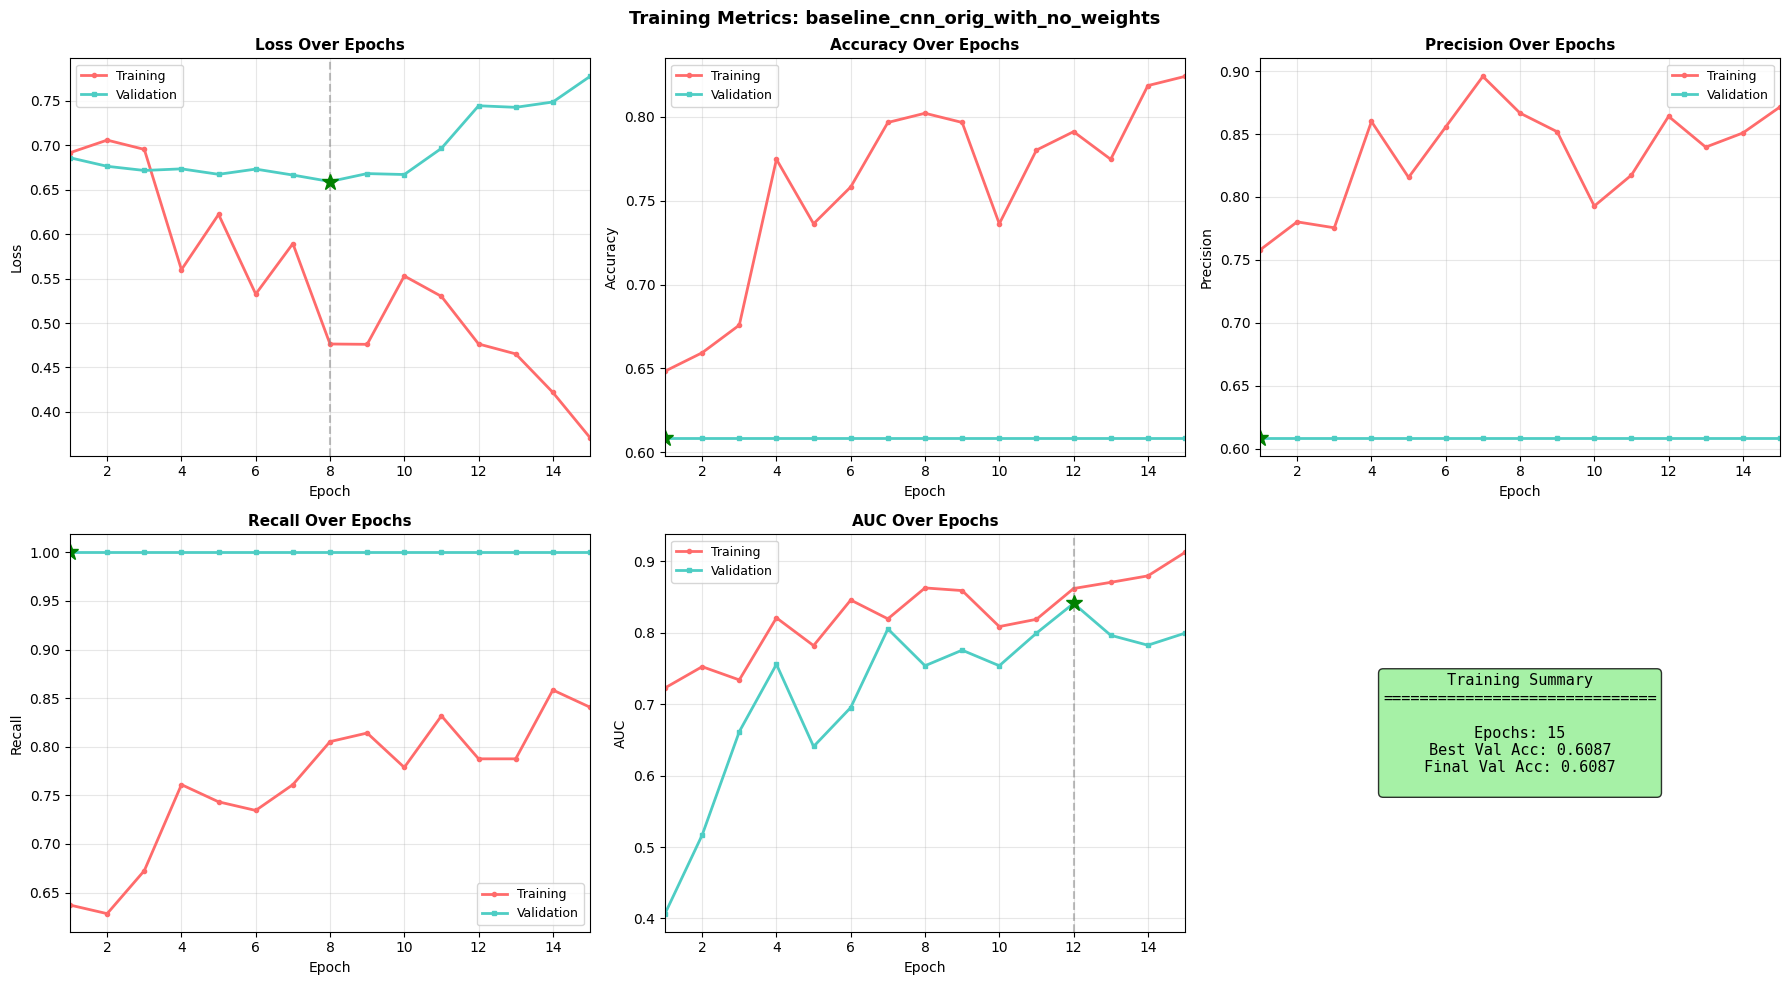

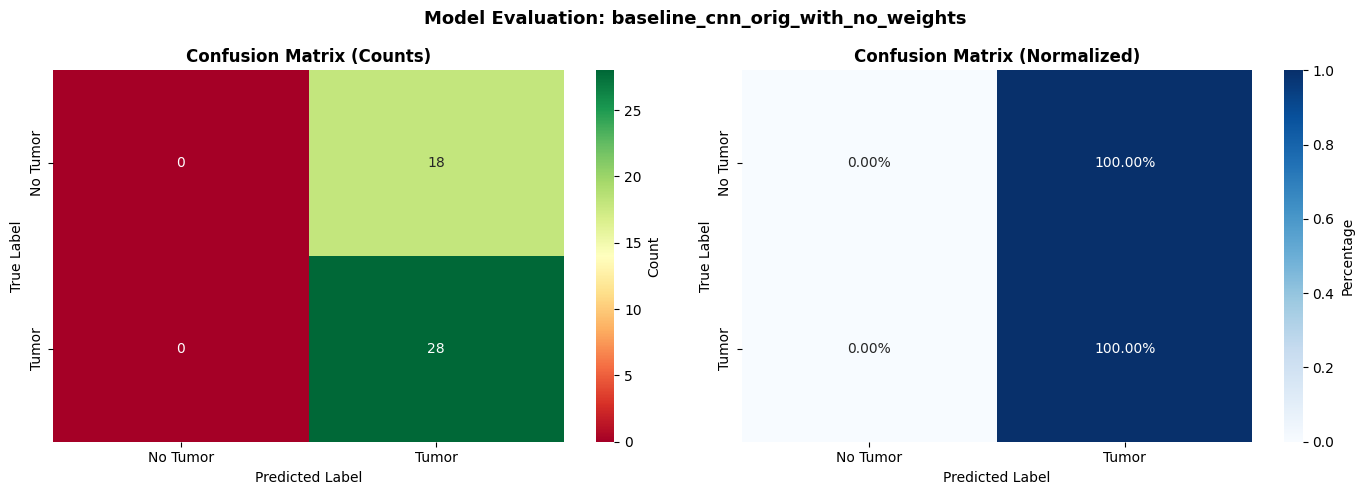


📊 Run Summary:
   Best Val Accuracy: 0.6087
   Best Val AUC: 0.8413
   Tumor Recall: 1.0000
   Tumor Precision: 0.6087

🎯 Optimizing Decision Threshold for baseline_cnn_orig_with_no_weights

📊 THRESHOLD OPTIMIZATION RESULTS:
------------------------------------------------------------

1️⃣ Maximum F1-Score Threshold:
   Threshold: 0.640
   Sensitivity (Tumor Recall): 85.7%
   Specificity (No Tumor Recall): 61.1%
   F1-Score: 0.814
   Accuracy: 76.1%

2️⃣ Balanced Performance Threshold:
   Threshold: 0.640
   Sensitivity (Tumor Recall): 85.7%
   Specificity (No Tumor Recall): 61.1%
   Balance Score: 1.468
   F1-Score: 0.814

3️⃣ Target Range (80-85% both) Threshold:
   ⚠️ No threshold in exact range, showing closest:
   Threshold: 0.650
   Sensitivity (Tumor Recall): 67.9%
   Specificity (No Tumor Recall): 72.2%
   F1-Score: 0.731

💾 Detailed results saved to: results/baseline_cnn_orig_with_no_weights_threshold_analysis.csv


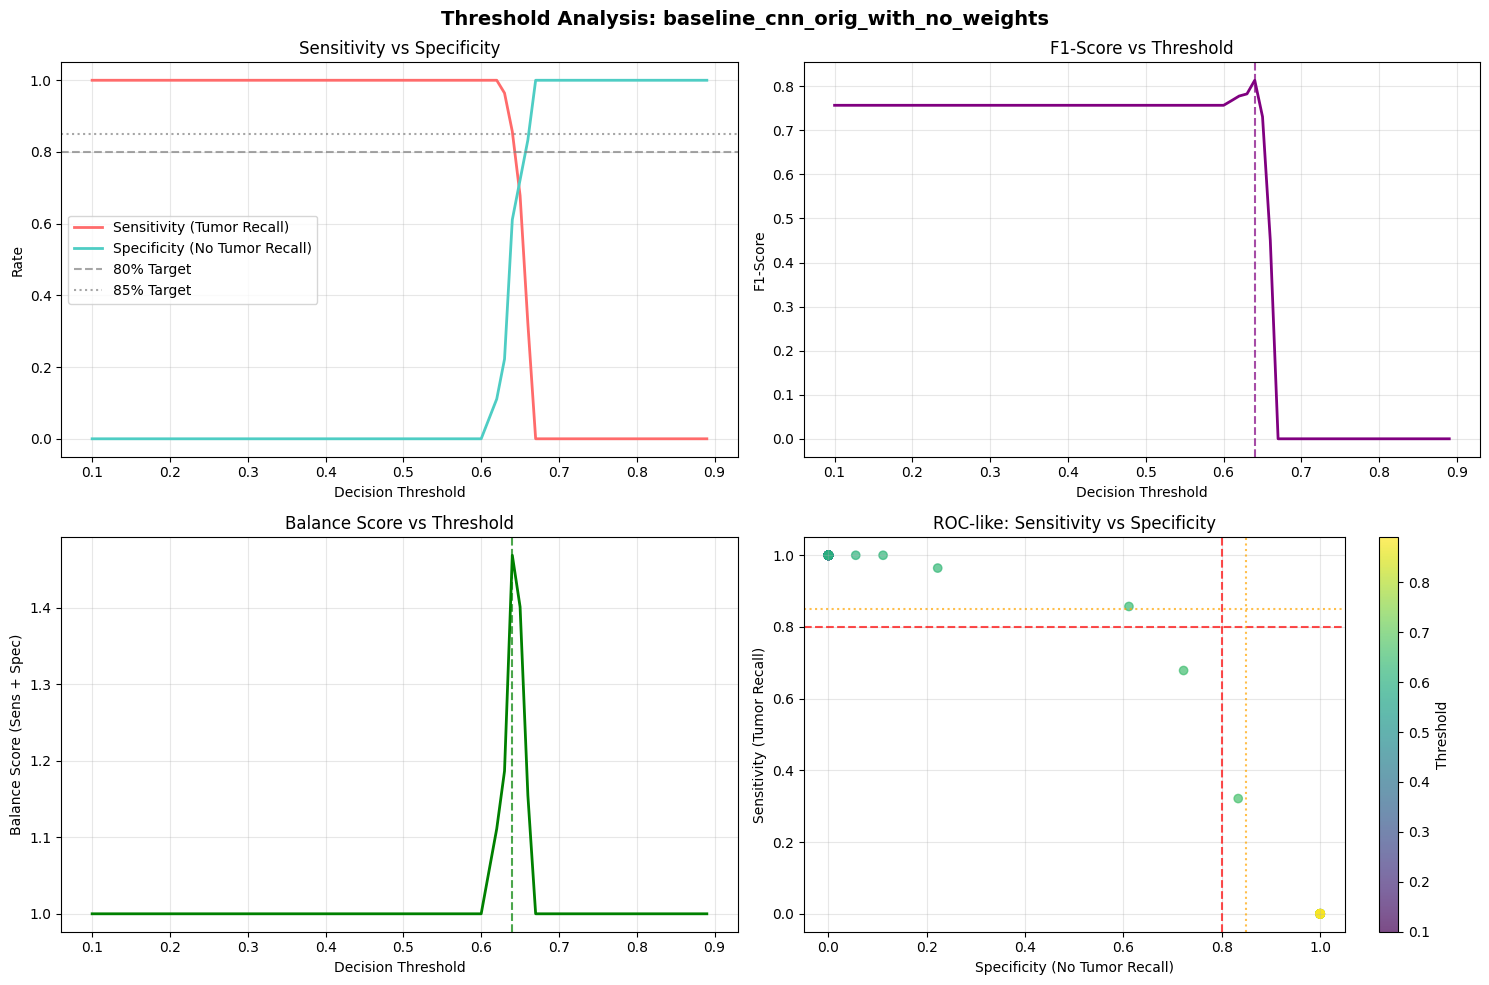


✅ Original baseline model training with no weights complete!

🎯 RECOMMENDED THRESHOLD: 0.650
   Use this threshold instead of 0.5 for balanced performance!


In [17]:
# ============================================================================
# BASELINE MODEL
# ============================================================================

print("\n" + "="*70)
print("SECTION 5: BASELINE MODEL TRAINING")
print("="*70)

baseline_params = {
    'filters_base': 32,
    'dropout_rate': 0.4,
    'dense_units': 256,
    'learning_rate': 0.001
}

print("\n📋 Baseline Configuration:")
for param, value in baseline_params.items():
    print(f"   {param}: {value}")

# Updated baseline training call to capture the threshold results:

baseline_history, baseline_model, baseline_run_id, baseline_threshold_results = train_and_log_model(
    run_name="baseline_cnn_orig_with_no_weights", # Updated name
    hyperparameters=baseline_params,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    class_weights=class_weights,  # Now using no weights (after trying reduced 1.3:1)
    epochs=25,
    batch_size=32,
    patience=7
)

print("\n✅ Original baseline model training with no weights complete!")

# Print recommended threshold
optimal_threshold = baseline_threshold_results['optimal_target']['threshold']
print(f"\n🎯 RECOMMENDED THRESHOLD: {optimal_threshold:.3f}")
print(f"   Use this threshold instead of 0.5 for balanced performance!")


In [ ]:
# # ============================================================================
# # BASELINE MODEL (SIMPLIFIED)
# # ============================================================================

# print("\n" + "="*70)
# print("SECTION 5: SIMPLIFIED BASELINE MODEL TRAINING")
# print("="*70)

# baseline_params = {
#     'filters_base': 16,    # ← Reduced
#     'dropout_rate': 0.3,   # ← Reduced
#     'dense_units': 128,    # ← Reduced
#     'learning_rate': 0.001
# }

# print("\n📋 Simplified Baseline Configuration:")
# for param, value in baseline_params.items():
#     print(f"   {param}: {value}")

# baseline_history, baseline_model, baseline_run_id, baseline_threshold_results = train_and_log_model(
#     run_name="baseline_cnn_simplified",
#     hyperparameters=baseline_params,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     class_weights=class_weights,  # ← Now None
#     epochs=30,        # ← Slightly more epochs
#     batch_size=16,    # ← Smaller batch size
#     patience=8        # ← More patience
# )

# print("\n✅ Simplified baseline model training complete!")


In [ ]:
# IMMEDIATELY run this check:
print("\n" + "="*70)
print("EMERGENCY LABEL CHECK")
print("="*70)

print(f"Training set:")
print(f"  Class 0 count: {np.sum(y_train == 0)}")
print(f"  Class 1 count: {np.sum(y_train == 1)}")

print(f"\nValidation set:")
print(f"  Class 0 count: {np.sum(y_val == 0)}")
print(f"  Class 1 count: {np.sum(y_val == 1)}")

print(f"\nExpected from Week 1:")
print(f"  No Tumor (class 0 - minority): ~87 → ~70 training, ~17 validation")
print(f"  Tumor (class 1 - majority): ~141 → ~113 training, ~28 validation")

# Check if it matches
if np.sum(y_train == 0) > np.sum(y_train == 1):
    print("\n🚨 LABELS ARE STILL REVERSED!")
    print("   Class 0 has MORE samples but should be minority")
    print("   YOU NEED TO FIX WEEK ONE DATA!")
else:
    print("\n✅ Labels appear correct")

In [ ]:
# ============================================================================
# CHECK LOSS VALUES DURING TRAINING
# ============================================================================

print("\n" + "="*60)
print("LOSS PROGRESSION CHECK")
print("="*60)

# Check if baseline_history exists
if 'baseline_history' in locals():
    print(f"\n📊 Training Loss Analysis:")
    print(f"  Initial training loss (epoch 1): {baseline_history.history['loss'][0]:.4f}")
    print(f"  Final training loss: {baseline_history.history['loss'][-1]:.4f}")
    print(f"  Initial validation loss (epoch 1): {baseline_history.history['val_loss'][0]:.4f}")
    print(f"  Final validation loss: {baseline_history.history['val_loss'][-1]:.4f}")
    
    # Check for problems
    initial_loss = baseline_history.history['loss'][0]
    if initial_loss < 0.5:
        print("\n🚨 PROBLEM: Initial loss too low!")
        print("   Binary crossentropy should start around 0.693")
        print("   Something is wrong with the loss function or data")
    elif initial_loss > 1.0:
        print("\n⚠️ WARNING: Initial loss higher than expected")
        print("   This might indicate learning rate is too high")
    else:
        print("\n✅ Initial loss looks reasonable")
        print("   Binary crossentropy starting around 0.693 is expected")
    
    # Check for convergence
    loss_improvement = initial_loss - baseline_history.history['loss'][-1]
    print(f"\n📈 Loss Improvement:")
    print(f"  Training loss decreased by: {loss_improvement:.4f}")
    print(f"  Improvement percentage: {(loss_improvement/initial_loss)*100:.1f}%")
    
    # Check for overfitting
    final_train_loss = baseline_history.history['loss'][-1]
    final_val_loss = baseline_history.history['val_loss'][-1]
    gap = final_val_loss - final_train_loss
    
    print(f"\n🎯 Overfitting Check:")
    print(f"  Final training loss: {final_train_loss:.4f}")
    print(f"  Final validation loss: {final_val_loss:.4f}")
    print(f"  Gap (val - train): {gap:.4f}")
    
    if gap > 0.1:
        print("  ⚠️ Possible overfitting detected")
    else:
        print("  ✅ No significant overfitting")
        
else:
    print("❌ baseline_history not found. Run the training cell first!")

In [ ]:
# ============================================================================
# DATA GENERATOR VERIFICATION
# ============================================================================

print("\n" + "="*70)
print("DATA GENERATOR CHECK")
print("="*70)

# Create fresh generators for testing (same as in training function)
test_train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator()

# Create test generators
train_test_generator = test_train_datagen.flow(
    X_train, y_train,
    batch_size=16,  # Smaller batch for testing
    shuffle=True,
    seed=RANDOM_SEED
)

val_test_generator = test_val_datagen.flow(
    X_val, y_val,
    batch_size=16,
    shuffle=False
)

# Test training generator (with augmentation)
print(f"\n🔍 TRAINING GENERATOR (With Augmentation):")
X_batch_train, y_batch_train = next(train_test_generator)

print(f"Batch shape: {X_batch_train.shape}")
print(f"Labels shape: {y_batch_train.shape}")
print(f"Labels in batch: {np.unique(y_batch_train, return_counts=True)}")
print(f"Pixel value range: [{X_batch_train.min():.3f}, {X_batch_train.max():.3f}]")

# Test validation generator (no augmentation)
print(f"\n🔍 VALIDATION GENERATOR (No Augmentation):")
X_batch_val, y_batch_val = next(val_test_generator)

print(f"Batch shape: {X_batch_val.shape}")
print(f"Labels shape: {y_batch_val.shape}")
print(f"Labels in batch: {np.unique(y_batch_val, return_counts=True)}")
print(f"Pixel value range: [{X_batch_val.min():.3f}, {X_batch_val.max():.3f}]")

# Visualize augmented vs original images
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Row 1: Original training images (first 6)
for i in range(6):
    if i < len(X_train):
        axes[0, i].imshow(X_train[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\nLabel: {int(y_train[i])}', fontsize=10)
        axes[0, i].axis('off')

# Row 2: Augmented training images
for i in range(6):
    if i < len(X_batch_train):
        axes[1, i].imshow(X_batch_train[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Augmented\nLabel: {int(y_batch_train[i])}', fontsize=10)
        axes[1, i].axis('off')

# Row 3: Validation images (should be identical to originals)
for i in range(6):
    if i < len(X_batch_val):
        axes[2, i].imshow(X_batch_val[i].squeeze(), cmap='gray')
        axes[2, i].set_title(f'Validation\nLabel: {int(y_batch_val[i])}', fontsize=10)
        axes[2, i].axis('off')

plt.suptitle('Data Generator Comparison: Original vs Augmented vs Validation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional checks
print(f"\n🔍 GENERATOR HEALTH CHECKS:")
print("="*50)

# Check if augmentation is working
X_batch_train2, y_batch_train2 = next(train_test_generator)
difference = np.mean(np.abs(X_batch_train - X_batch_train2))
print(f"Difference between consecutive augmented batches: {difference:.6f}")

if difference > 0.001:
    print("✅ Augmentation is working - batches are different")
else:
    print("⚠️ Augmentation might not be working - batches are too similar")

# Check label distribution consistency
print(f"\nLabel distribution in training batch 1: {np.bincount(y_batch_train.astype(int))}")
print(f"Label distribution in training batch 2: {np.bincount(y_batch_train2.astype(int))}")
print(f"Label distribution in validation batch: {np.bincount(y_batch_val.astype(int))}")

# Check for data leakage between generators
train_hashes = {hash(img.tobytes()) for img in X_batch_train.reshape(len(X_batch_train), -1)}
val_hashes = {hash(img.tobytes()) for img in X_batch_val.reshape(len(X_batch_val), -1)}
generator_overlap = len(train_hashes & val_hashes)

print(f"\nData leakage check between generator batches: {generator_overlap} overlapping images")
if generator_overlap == 0:
    print("✅ No data leakage between train/val generators")
else:
    print("⚠️ Potential data leakage detected in generators")

# Test multiple batches to ensure variety
print(f"\n🔍 TESTING AUGMENTATION VARIETY:")
print("="*40)

augmentation_differences = []
base_batch = X_batch_train.copy()

for i in range(5):
    new_batch, _ = next(train_test_generator)
    diff = np.mean(np.abs(base_batch - new_batch))
    augmentation_differences.append(diff)
    print(f"Batch {i+1} difference from base: {diff:.6f}")

avg_difference = np.mean(augmentation_differences)
print(f"\nAverage augmentation difference: {avg_difference:.6f}")

if avg_difference > 0.01:
    print("✅ Strong augmentation variety detected")
elif avg_difference > 0.001:
    print("✅ Moderate augmentation variety detected")
else:
    print("⚠️ Low augmentation variety - consider increasing augmentation parameters")

print(f"\n💡 RECOMMENDATIONS:")
print("="*30)
if avg_difference > 0.05:
    print("⚠️ Augmentation might be too aggressive - could hurt performance")
elif avg_difference < 0.001:
    print("💡 Consider increasing augmentation parameters for more variety")
else:
    print("✅ Augmentation levels appear reasonable")

**After reducing data augmentation and re-running the original model, performance is still very poor**
- Tumor Recall: 100% + Tumor Precision: 60.87% = Model predicts tumor for nearly everything
- validation loss barely improves
- Training breakdown:
  - No Tumor (minority): ~70 images
  - Tumor (majority): ~113 images
  - 1,000+ images per class minimum recommendation

**Takeaway: dataset is too small for training a CNN from scratch - MUST use transfer learning.**

**RECOMMENDED: MobileNetV2:**

✅ Edge detection (learned from 1.4M images)

✅ Texture patterns

✅ Shape recognition

✅ Complex features

**I will proceed with the recommendation in week 3.**